In [1]:
import scipy as sc
from sklearn import datasets
from matplotlib.style import available
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
import numpy as np
import cvxpy as cp
import torch
import time
from cvxpylayers.torch import CvxpyLayer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import warnings
import mosek
warnings.filterwarnings('ignore')
plt.rcParams.update({
    "text.usetex":True,
    "font.size":18,
    "font.family": "serif"
})
colors = ["tab:blue", "tab:green", "tab:orange", 
          "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:grey", "tab:olive","tab:blue", "tab:orange", "tab:green",
          "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:grey", "tab:olive"]

In [4]:
def createproblem_port(N, m):
    """Create the problem in cvxpy, minimize CVaR
    Parameters
    ----------
    N: int
        Number of data samples
    m: int
        Size of each data sample
    Returns
    -------
    The instance and parameters of the cvxpy problem
    """
    # PARAMETERS #
    dat = cp.Parameter((N, m))
    eps = cp.Parameter()
    w = cp.Parameter(N)
    a = -5

    # VARIABLES #
    # weights, s_i, lambda, tau
    x = cp.Variable(m)
    s = cp.Variable(N)
    lam = cp.Variable()
    tau = cp.Variable()
    y = cp.Variable()
    # OBJECTIVE #
    objective = tau + y

    # CONSTRAINTS #
    constraints = [cp.multiply(eps, lam) + w@s <= y]
    constraints += [cp.hstack([a*tau]*N) + a*dat@x +
                    cp.hstack([cp.quad_over_lin(-a*x, 4*lam)]*N) <= s]
    constraints += [cp.sum(x) == 1]
    constraints += [x >= 0, x <= 1]
    # for k in range(2):
    #    constraints += [cp.sum(x[k*np.ceil(m/2):(k+1)*np.ceil(m/2)]) <= 0.50]
    constraints += [lam >= 0, y >=0]
    # PROBLEM #
    problem = cp.Problem(cp.Minimize(objective), constraints)
    return problem, x, s, tau, y, lam, dat, eps, w


In [5]:
def loss_eval_k(test):
    """Defines the function to differentiate"""
    x_val, s_val, tau_val, y_val, l_val = cvxpylayer(dat_tch, torch.pow(
        torch.tensor(10.0, requires_grad=True), log_eps_tch), w_tch,solver_args={'solve_method':'ECOS'})  # check
    lt = torch.matmul(torch.tensor(test, requires_grad=True), x_val)
    lt2 = torch.matmul(torch.tensor(d_eval, requires_grad=True), x_val)
    obj = tau_val + y_val
    return torch.mean(torch.maximum(-5*lt -4*tau_val, tau_val)), obj, torch.mean(torch.maximum(-5*lt2 -4*tau_val, tau_val))

In [125]:
def createBf(m, N, k):
    """ Create betas for k-factor model"""
    B = np.random.uniform(-0.2, 0.9, (m, k))
    f = [np.random.normal(0, 0.02*(i+1), N) for i in range(1, k+1)]
    return B, f

def factor_returns(m, N, k, B, f):
    """ Create k-factor model return data"""
    Systematic = B@f
    R = np.vstack(Systematic + [np.random.normal(
        i*0.03, (i**2)*0.05, N) for i in range(1, m+1)])
    Covu = np.diag([i*0.05 for i in range(1, m+1)])
    Covf = np.diag([i*0.02 for i in range(1, k+1)])
    Cov = B@Covf@(B.T) + Covu
    return (R.transpose()), Cov

In [126]:
def createBf1(m, N, k):
    """ Create betas for k-factor model"""
    B = np.random.uniform(-0.2, 0.9, (m, k))
    f = [np.random.normal(0, 0.02*(i+1)) for i in range(1, k+1)]
    return B, f

def factor_returns1(m, N, k, B, f):
    """ Create k-factor model return data"""
    Systematic = B@f
    R = np.vstack(np.vstack([Systematic]*N).T + [np.random.normal(
        i*0.03, (i**2)*0.05, N) for i in range(1, m+1)])
    Covu = np.diag([i*0.025 for i in range(1, m+1)])
    Covf = np.diag([i*0.02 for i in range(1, k+1)])
    Cov = B@Covf@(B.T) + Covu
    return (R.transpose()), Cov

def createBf2(m, N, k):
    """ Create betas for k-factor model"""
    B = np.random.uniform(-0.3, 0.8, (m, k))
    f = [np.random.normal(0, 0.03*(i+1), N) for i in range(1, k+1)]
    return B, f

def factor_returns2(m, N, k, B, f):
    """ Create k-factor model return data"""
    Systematic = B@f
    R = np.vstack(Systematic + [np.random.normal(
        i*0.01, (i**2)*0.03, N) for i in range(1, m+1)])
    Covu = np.diag([i*0.03 for i in range(1, m+1)])
    Covf = np.diag([i*0.01 for i in range(1, k+1)])
    Cov = B@Covf@(B.T) + Covu
    return (R.transpose()), Cov

In [8]:
synthetic_returns = pd.read_csv(
        '../mro_codecopy/portfolio/sp500_synthetic_returns.csv').to_numpy()[:, 1:]

In [10]:
m = 30
N = 300
data= synthetic_returns[:3000,:m]*20
dateval = synthetic_returns[-3000:,:m]*20
## SYNTHETIC DATA

In [128]:
m = 20
N = 300
B,f = createBf(m,N,5)
B2,f2 = createBf2(m,N,5)

In [152]:
data = np.zeros((10*N,m))
dateval = np.zeros((10*N,m))
for r in range(10):
    d1, _ = factor_returns(m, N, 5, B,f)
    d2, _ = factor_returns2(m, N, 5, B2,f2)
    data[(N*r):int(N*(r+0.5))] = d1[:int(N/2)]
    data[int(N*(r+0.5)):(N*(r+1))] = d2[:int(N/2)]
    dateval[(N*r):int(N*(r+0.5))] = d1[int(N/2):]
    dateval[int(N*(r+0.5)):(N*(r+1))] = d1[int(N/2):]

In [157]:
df = pd.DataFrame(columns = ["r","K","steps","Epsilon","Opt_val","Eval_val","Loss_val","satisfy","solvetime","grad"])
m = 20
N = 300
Num_left = N - int(N/5)
#dateval = synthetic_returns[-5000:, :m]
#B,f = createBf(m,2*N,5)
#data, datacov = factor_returns(m, 2*N, 5, B,f)
#dateval = data[:10*N]
#data = data[10*N:]
K_nums = np.append([1,2,3,4,5],np.append(np.arange(20, int(Num_left/2)+1,50), Num_left))
#data = synthetic_returns[5000:10000, :m]
for r in range(5):
    d_eval = dateval[(N*r):(N*(r+1))]
    d_train = data[(N*r):(N*(r+1))]
    for K in K_nums:
        print(K)
        problem, x, s, tau, y, l, dat, eps,w = createproblem_port(K, m)
        cvxpylayer = CvxpyLayer(problem, parameters=[
                                dat, eps,w], variables=[x, s,tau,y,l])
        epsv = np.float64(1.5)
        log_eps_tch = torch.tensor(epsv, requires_grad=True)

        variables = [log_eps_tch]
        opt = torch.optim.SGD(variables, lr=.05, momentum=.8)
        step = 30
        for steps in range(step):
            tstart = time.time()
            totloss = 0
            prob = 0
            objv = 0
            evalvs = 0
            splits = 5
            kf = KFold(n_splits = splits)
            for train_index, test_index in kf.split(d_train):
                train, test = d_train[train_index], d_train[test_index]
                kmeans = KMeans(n_clusters=K).fit(train)
                weights = np.bincount(kmeans.labels_) / len(train)
                w_tch = torch.tensor(weights,requires_grad = True)
                val_dset = torch.tensor(test, requires_grad=True)
                dat_tch = torch.tensor(kmeans.cluster_centers_, requires_grad=True)
                temploss, obj, evalv = loss_eval_k(val_dset)
                prob += (evalv.item() <= (temploss.item())) #is constraint satisfied for OOS
                objv += obj
                totloss += temploss
                evalvs += evalv
            totloss = totloss/splits
            totloss.backward()
            #print(evalvs.item()/splits,log_eps_tch.grad)
            newrow = pd.Series(
                {"r":r,
                 "K": K,
                 "steps": steps,
                 "Epsilon": np.sqrt(10**(log_eps_tch.clone().detach().numpy())),
                 "Loss_val": totloss.item(), 
                 
                 "Opt_val":objv.item()/splits,
                 "Eval_val":evalvs.item()/splits, # graphing
                 "satisfy": prob/splits,
                 "solvetime": time.time() - tstart,
                 "grad": log_eps_tch.grad
            })
            df = df.append(newrow,ignore_index = True)
            opt.step()
            opt.zero_grad()
        print(totloss.item())

1
2.6837249819799522
2
2.683722248191516
3
2.68373077381746
4
2.683729322202415
5
2.684539308179054
20
3.8376151187435132
70
3.1027035442152107
120
2.8405902648200154
240
3.1996375205028915
1
2.4447297304724023
2
2.444733690370307
3
2.444735935155772
4
2.444733286251878
5
2.444683666567884
20
3.2710627432725756
70
2.834762547610983
120
2.7048460650689288
240
2.9562598163937936
1
2.609980624426115
2
2.6099857583209216
3
2.609975134081966
4
2.6098118047507546
5
2.6084312380321464
20
4.076796089084941
70
3.3816722138270143
120
3.1138793232877977
240
3.5549202547020267
1
2.7946091718692765
2
2.7946160771559936
3
2.794604707854721
4
2.7938721913067597
5
2.794796572079067
20
4.578569971431806
70
3.7473298738241128
120
3.3051054618501174
240
4.044517137047876
1
2.686995879353861
2
2.687001291498985
3
2.6914718276275966
4
2.6872455866965548
5
2.695958637852755
20
4.09090873596709
70
3.337517176566066
120
3.06687036700987
240
3.492549560442744


### Average results over experiments

In [158]:
dftemp = df[df["r"]==0].reset_index()
for r in range(1,5):
    dftemp = dftemp.add(df[df["r"] == r].reset_index(), fill_value = 0)
dftemp = dftemp/(5)

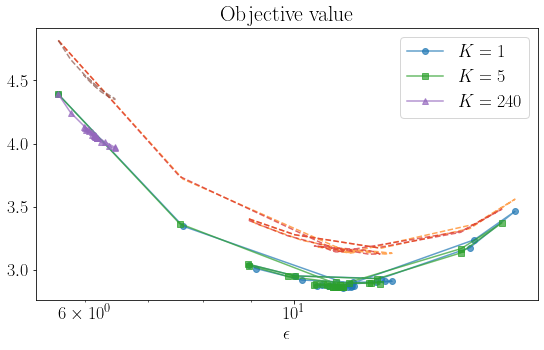

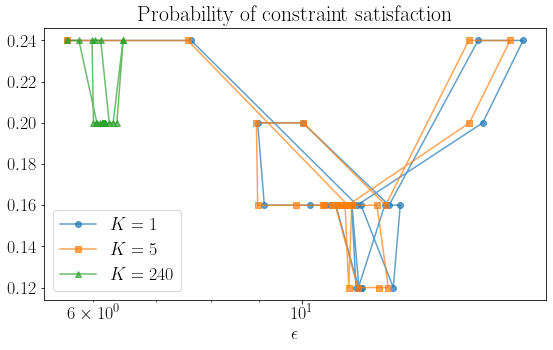

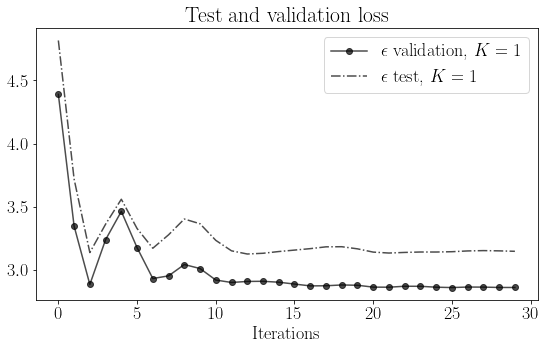

In [103]:
plt.figure(figsize=(9, 5))
styles = ["o",'s',"^","v","<",">","o",'s',"^","v","<",">"]
j = 0
for K_count in np.arange(0,len(K_nums),4):
    plt.plot(dftemp.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["Epsilon"], dftemp.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["Loss_val"], linestyle='-', marker=styles[j], label="$K = {}$".format(K_nums[K_count]),alpha = 0.7)
    plt.plot(dftemp.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["Epsilon"], dftemp.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["Eval_val"], linestyle='--',alpha = 0.7)
    j+=1
plt.xlabel("$\epsilon$")
plt.title("Objective value")
plt.xscale("log")
plt.legend()
plt.show()

plt.figure(figsize=(9, 5))
styles = ["o",'s',"^","v","<",">","o",'s',"^","v","<",">"]
j = 0
for K_count in np.arange(0,len(K_nums),4):
    plt.plot(dftemp.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["Epsilon"], dftemp.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["satisfy"], linestyle='-', marker=styles[j], label="$K = {}$".format(K_nums[K_count]),alpha = 0.7)
    j+=1
plt.xlabel("$\epsilon$")
plt.title("Probability of constraint satisfaction")
plt.xscale("log")
plt.legend()
plt.show()


plt.figure(figsize=(9, 5))
styles = ["o",'s',"^","v","<",">","o",'s',"^","v","<",">"]
j = 0
for K_count in [0]:
    plt.plot(dftemp.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["steps"], dftemp.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["Loss_val"],  label="$\epsilon$ validation, $K = {}$".format(K_nums[K_count]), color = "black",linestyle='-', marker=styles[j],alpha = 0.7)   
    plt.plot(dftemp.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["steps"], dftemp.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["Eval_val"], color = "black",linestyle='-.',alpha = 0.7,label="$\epsilon$ test, $K = {}$".format(K_nums[K_count]))
    j+=1
plt.xlabel("Iterations")
plt.title("Test and validation loss")
plt.legend()
plt.show()


### Gridsearch for epsilon

In [153]:
Data = data
Data_eval = dateval
df1 = pd.DataFrame(columns=["r","K", "Epsilon", "Opt_val", "Eval_val",
                           "satisfy", "solvetime", "setuptime", "clustertime"])
eps_nums = np.logspace(-2,2)
x_sols = np.zeros((len(K_nums), len(eps_nums), m, 10))

for r in range(5):
    for K_count, K in enumerate(K_nums):
        print(r, K)
        if K == N:
            kmeans = KMeans(n_clusters=K).fit(Data[(N*r):(N*(r+1))])
            wk = np.bincount(kmeans.labels_) / N
            clustertimes = 0
        else:
            tnow = time.time()
            kmeans = KMeans(n_clusters=K).fit(Data[(N*r):(N*(r+1))])
            wk = np.bincount(kmeans.labels_) / N
            clustertimes = time.time() - tnow
        d_eval = Data_eval[(N*r):(N*(r+1))]
        tnow = time.time()
        problem, x, s, tau,y, lmbda, data_train_pm, eps_pm, w_pm = createproblem_port(K, m)
        data_train_pm.value = kmeans.cluster_centers_
        w_pm.value = wk
        setuptimes = time.time() - tnow

        ######### solve for various epsilons ############
        for eps_count, eps in enumerate(eps_nums):
            eps_pm.value = eps**2
            problem.solve(solver=cp.MOSEK,mosek_params={
                          mosek.dparam.optimizer_max_time:  1000.0})
            evalvalue = np.mean(np.maximum(-5*x.value@d_eval.T - 4*tau.value,tau.value))
            x_sols[K_count, eps_count, :, r] = x.value
            newrow = pd.Series(
                {"r": r,
                 "K": K,
                 "Epsilon": eps,
                 "Opt_val": problem.objective.value,
                 "Eval_val": evalvalue,
                 "satisfy": evalvalue <= (problem.objective.value + 1e-9),
                 "solvetime": problem.solver_stats.solve_time,
                 "setuptime": setuptimes,
                 "clustertime": clustertimes
                 })
            df1 = df1.append(newrow, ignore_index=True)

0 1
0 2
0 3
0 4
0 5
0 20
0 70
0 120
0 240
1 1
1 2
1 3
1 4
1 5
1 20
1 70
1 120
1 240
2 1
2 2
2 3
2 4
2 5
2 20
2 70
2 120
2 240
3 1
3 2
3 3
3 4
3 5
3 20
3 70
3 120
3 240
4 1
4 2
4 3
4 4
4 5
4 20
4 70
4 120
4 240


In [154]:
dftemp1 = df1[df1["r"]==0].reset_index()
for r in range(1,5):
    dftemp1 = dftemp1.add(df1[df1["r"] == r].reset_index(), fill_value = 0)
dftemp1 = dftemp1/(5)

In [44]:
dftemp =  pd.read_csv('real_rets20_noreg/dftemp.csv')
dftemp1 =  pd.read_csv('real_rets20_noreg/dftemp1.csv')
dftemp2 =  pd.read_csv('real_rets20_noreg/dftemp2.csv')

In [47]:
np.min(dftemp[dftemp["K"]==1]["Eval_val"])

0.2028513499750343

In [31]:
dftemp2 = df2[df2["r"]==0].reset_index()

In [56]:
dftemp1 = df1[df1["r"]==0].reset_index()
dftemp = df[df["r"]==0].reset_index()
dftemp2 = df2[df2["r"]==0].reset_index()

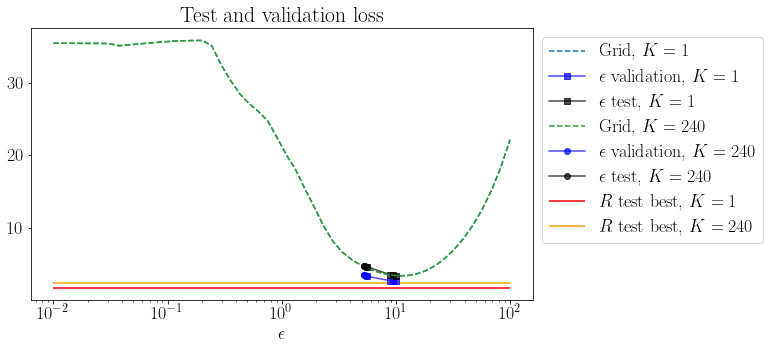

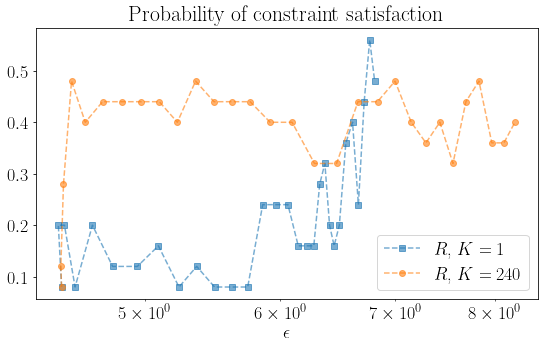

In [163]:
plt.figure(figsize=(9, 5))
styles = ["s",'o',"^","v","<",">","o",'s',"^","v","<",">"]
j = 0
#for K_count in np.arange(0,len(K_nums),2):
for K_count in [0,len(K_nums)-1]:
    #plt.plot(dftemp1.sort_values(["K","Epsilon"])[K_count*len(eps_nums):(K_count+1)*len(eps_nums)]["Epsilon"], dftemp1.sort_values(["K","Epsilon"])[K_count*len(eps_nums):(K_count+1)*len(eps_nums)]["Opt_val"], color = colors[j], linestyle='-', marker=styles[j], label="Grid, $K = {}$".format(K_nums[K_count]),alpha = 0.7)
    plt.plot(dftemp1.sort_values(["K","Epsilon"])[K_count*len(eps_nums):(K_count+1)*len(eps_nums)]["Epsilon"], dftemp1.sort_values(["K","Epsilon"])[K_count*len(eps_nums):(K_count+1)*len(eps_nums)]["Eval_val"], color = colors[j], linestyle='--',label="Grid, $K = {}$".format(K_nums[K_count]))
    plt.plot(dftemp.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["Epsilon"][0:step:8], dftemp.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["Loss_val"][0:step:8], linestyle='-', marker=styles[j], color = "blue", label="$\epsilon$ validation, $K = {}$".format(K_nums[K_count]),alpha = 0.7)
    plt.plot(dftemp.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["Epsilon"][0:step:8], dftemp.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["Eval_val"][0:step:8], linestyle='-', marker=styles[j], color = "black", label="$\epsilon$ test, $K = {}$".format(K_nums[K_count]),alpha = 0.7)
    j+=1
plt.hlines( xmin = 1e-2, xmax = 10**(2), y = np.min(dftemp2[dftemp2["K"]==1]["Eval_val"]), label = "$R$ test best, $K = 1$", color= "red")
plt.hlines( xmin = 1e-2, xmax = 10**(2), y = np.min(dftemp2[dftemp2["K"]==240]["Eval_val"]), label = "$R$ test best, $K = 240$", color= "orange")

plt.xlabel("$\epsilon$")
plt.title("Test and validation loss")
plt.xscale("log")
#plt.xlim([10**(-1),10**0.5])
#plt.ylim([.1,1])
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig("loss.pdf")
plt.show()
plt.figure(figsize=(9, 5))
styles = ["s",'o',"^","v","<",">","o",'s',"^","v","<",">"]
j = 0
for K_count in [0,len(K_nums)-1]:
    #plt.plot(dftemp1.sort_values(["K","Epsilon"])[K_count*len(eps_nums):(K_count+1)*len(eps_nums)]["Epsilon"], dftemp1.sort_values(["K","Epsilon"])[K_count*len(eps_nums):(K_count+1)*len(eps_nums)]["satisfy"], linestyle='-', marker=styles[j], label="Grid, $K = {}$".format(K_nums[K_count]),alpha = 0.6)
    #plt.plot(dftemp.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["Epsilon"], dftemp.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["satisfy"], linestyle='--', marker=styles[j], label="$\epsilon$, $K = {}$".format(K_nums[K_count]),alpha = 0.6)
    plt.plot(dftemp2.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["Rnorm"], dftemp2.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["satisfy"], linestyle='--', marker=styles[j], label="$R$, $K = {}$".format(K_nums[K_count]),alpha = 0.6)
    j+=1
plt.xlabel("$\epsilon$")
plt.title("Probability of constraint satisfaction")
plt.xscale("log")
plt.legend()
plt.show()

# Reshape

In [65]:
def createproblem_portR(N, m):
    """Create the problem in cvxpy, minimize CVaR
    Parameters
    ----------
    N: int
        Number of data samples
    m: int
        Size of each data sample
    Returns
    -------
    The instance and parameters of the cvxpy problem
    """
    # PARAMETERS #
    datR = cp.Parameter((N, m))
    w = cp.Parameter(N)
    R = cp.Parameter((m,m))
    a = -5

    # VARIABLES #
    # weights, s_i, lambda, tau
    x = cp.Variable(m)
    x1 = cp.Variable(m)
    s = cp.Variable(N)
    lam = cp.Variable()
    tau = cp.Variable()
    y = cp.Variable()
    # OBJECTIVE #
    objective = tau + y

    # CONSTRAINTS #
    constraints = [lam + w@s <= y]
    constraints += [cp.hstack([a*tau]*N) + a*datR@x +
                    cp.hstack([cp.quad_over_lin(-a*x1, 4*lam)]*N) <= s]
    constraints += [R.T@x1 ==x]
    constraints += [cp.sum(x) == 1]
    constraints += [x >= 0, x <= 1]
    # for k in range(2):
    #    constraints += [cp.sum(x[k*np.ceil(m/2):(k+1)*np.ceil(m/2)]) <= 0.50]
    constraints += [lam >= 0, y >=0]
    # PROBLEM #
    problem = cp.Problem(cp.Minimize(objective), constraints)
    return problem, x, x1, s, tau, y, lam, datR, w, R


In [66]:
def loss_evalR(test):
    """New outer loss function"""
    x_val, x1_val, s_val, tau_val,y_val, l_val = cvxpylayer(dat_R_tch, w_tch, R_tch,solver_args={'solve_method':'ECOS'})  # check
    lt = torch.matmul(torch.tensor(test, requires_grad=True), x_val)
    lt2 = torch.matmul(torch.tensor(d_eval, requires_grad=True), x_val)
    obj = tau_val + y_val
    return torch.mean(torch.maximum(-5*lt -4*tau_val, tau_val)), obj, torch.mean(torch.maximum(-5*lt2 -4*tau_val, tau_val))

In [117]:
np.save("B",B)
np.save("f",f)
np.save("dateval",dateval)
np.save("data",data)

In [159]:
df2 = pd.DataFrame(columns = ["r","K","steps","Rnorm","Opt_val","Eval_val","Loss_val","satisfy","solvetime"])
Num_left = N - int(N/5)
K_nums = np.append([1,2,3,4,5],np.append(np.arange(20, int(Num_left/2)+1,50), Num_left))
Rmats = []
for r in range(5):
    d_eval = dateval[(N*r):(N*(r+1))]
    d_train = data[(N*r):(N*(r+1))]
    allrs = []
    for K in K_nums:
        print(K)
        #B = createB(10, 5)
        #data, datacov = factor_returns(m, N, 5, B)
        #data = normal_returns(N, m)
        
        problem, x, x1, s, tau, y, l, datR,w, R= createproblem_portR(K, m)
        cvxpylayer = CvxpyLayer(problem, parameters=[
                                datR,w,R], variables=[x, x1, s,tau,y,l])
        Rv = np.identity(m)*1
        R_tch = torch.tensor(Rv, requires_grad=True)
        variables = [R_tch]
        opt = torch.optim.SGD(variables, lr=.02, momentum=.8)
        step = 30
        Rs_val = []
        for steps in range(step):
            tstart = time.time()
            totloss = 0
            prob = 0
            objv = 0
            evalvs = 0
            splits = 5
            kf = KFold(n_splits = splits)
            for train_index, test_index in kf.split(d_train):
                train, test = d_train[train_index], d_train[test_index]
                kmeans = KMeans(n_clusters=K).fit(train)
                weights = np.bincount(kmeans.labels_) / len(train)
                w_tch = torch.tensor(weights,requires_grad = True)
                val_dset = torch.tensor(test, requires_grad=True)
                dat_tch = torch.tensor(kmeans.cluster_centers_, requires_grad=True)
                dat_R_tch = (R_tch@dat_tch.T).T
                temploss, obj, evalv = loss_evalR(val_dset)
                prob += (evalv.item() <= (temploss.item() + 1e-10))
                objv += obj + 1e-10
                totloss += temploss
                evalvs += evalv
            totloss = totloss/splits
            totloss.backward()
            #print(totloss.item())
            Rs_val.append(R_tch.detach().numpy().copy())
            newrow = pd.Series(
                {"r":r,
                 "K": K,
                 "steps": steps,
                 "Rnorm": np.linalg.norm(R_tch.detach().numpy().copy()),
                 "Loss_val": totloss.item(),
                 "Opt_val":objv.item()/splits,
                 "Eval_val":evalvs.item()/splits,
                 "satisfy": prob/splits,
                 "solvetime": time.time() - tstart
            })
            df2 = df2.append(newrow,ignore_index = True)
            opt.step()
            opt.zero_grad()
        print(totloss.item())
        allrs.append(Rs_val)
    Rmats.append(allrs)

1
0.19355940955766177
2
0.676166940837165
3
0.6428917538563106
4
0.5312493318750923
5
0.21382790680723315
20
7.0537230659771195
70
1.8619364751972978
120
0.8263566168537663
240
1.7959784350063548
1
0.4448686142425684
2
0.6763970021106517
3
1.5896896795571178
4
0.7681701844390305
5
1.511091022693753
20
26.400019070168895
70
4.382989980246757
120
0.821435896962013
240
3.7532613575421054
1
0.1888764406436653
2
0.1700278928339572
3
0.390269870771235
4
0.2764778059748654
5
0.40744009137693943
20
37.44284822842455
70
28.415116104782026
120
1.626321764258456
240
29.4111520422544
1
9.040425561582488
2
2.171141514529587
3
3.7479276243245536
4
1.975994886712104
5
0.8151559888731855
20
45.261583810486414
70
24.450457749373122
120
27.88847417298579
240
36.85233010639904
1
0.34019452170756037
2
4.303410960194671
3
1.4332565938384199
4
2.731393691484194
5
1.7207180551801056
20
28.26813450074374
70
8.15395271895567
120
5.99435699369585
240
2.6793328253998645


In [160]:
dftemp2 = df2[df2["r"]==0].reset_index()
for r in range(1,5):
    dftemp2 = dftemp2.add(df2[df2["r"] == r].reset_index(), fill_value = 0)
dftemp2 = dftemp2/(5)

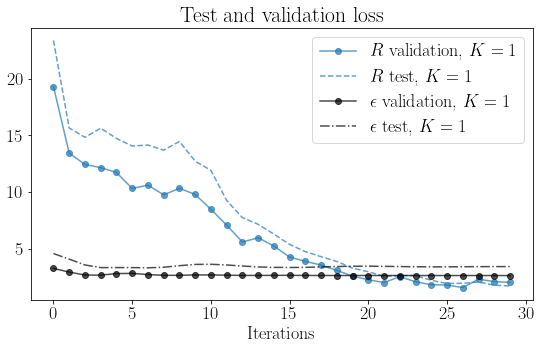

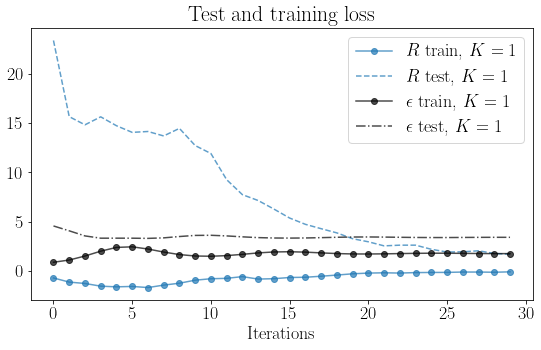

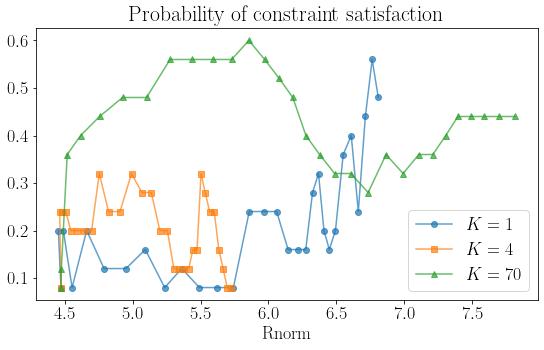

In [166]:
plt.figure(figsize=(9, 5))
styles = ["o",'s',"^","v","<",">","o",'s',"^","v","<",">"]
j = 0
#, len(K_nums)-1
for K_count in [0]:
    plt.plot(dftemp2.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["steps"], dftemp2.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["Loss_val"], color = colors[j], linestyle='-', marker=styles[j], label="$R$ validation, $K = {}$".format(K_nums[K_count]),alpha = 0.7)
    plt.plot(dftemp2.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["steps"], dftemp2.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["Eval_val"],  color = colors[j], linestyle='--',alpha = 0.7,label="$R$ test, $K = {}$".format(K_nums[K_count]))
    plt.plot(dftemp.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["steps"], dftemp.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["Loss_val"],  label="$\epsilon$ validation, $K = {}$".format(K_nums[K_count]), color = "black",linestyle='-', marker=styles[j],alpha = 0.7)   
    plt.plot(dftemp.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["steps"], dftemp.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["Eval_val"], color = "black",linestyle='-.',alpha = 0.7,label="$\epsilon$ test, $K = {}$".format(K_nums[K_count]))
    j+=1
plt.xlabel("Iterations")
plt.title("Test and validation loss")
plt.legend()
plt.show()

plt.figure(figsize=(9, 5))
styles = ["o",'s',"^","v","<",">","o",'s',"^","v","<",">"]
j = 0
for K_count in [0]:
    plt.plot(dftemp2.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["steps"], dftemp2.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["Opt_val"], color = colors[j], linestyle='-', marker=styles[j], label="$R$ train, $K = {}$".format(K_nums[K_count]),alpha = 0.7)
    plt.plot(dftemp2.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["steps"], dftemp2.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["Eval_val"],  color = colors[j], linestyle='--',alpha = 0.7,label="$R$ test, $K = {}$".format(K_nums[K_count]))
    plt.plot(dftemp.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["steps"], dftemp.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["Opt_val"],  label="$\epsilon$ train, $K = {}$".format(K_nums[K_count]), color = "black",linestyle='-', marker=styles[j],alpha = 0.7)   
    plt.plot(dftemp.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["steps"], dftemp.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["Eval_val"], color = "black",linestyle='-.',alpha = 0.7,label="$\epsilon$ test, $K = {}$".format(K_nums[K_count]))
    j+=1
plt.xlabel("Iterations")
plt.title("Test and training loss")
plt.legend()
plt.savefig("iters.pdf")
plt.show()

plt.figure(figsize=(9, 5))
styles = ["o",'s',"^","v","<",">","o",'s',"^","v","<",">"]
j = 0
for K_count in np.arange(0,len(K_nums),3):
    plt.plot(dftemp2.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["Rnorm"], dftemp2.sort_values(["K","steps"])[K_count*step:(K_count+1)*step]["satisfy"], linestyle='-', marker=styles[j], label="$K = {}$".format(K_nums[K_count]),alpha = 0.7)
    j+=1
plt.xlabel("Rnorm")
plt.title("Probability of constraint satisfaction")
plt.legend()
plt.show()

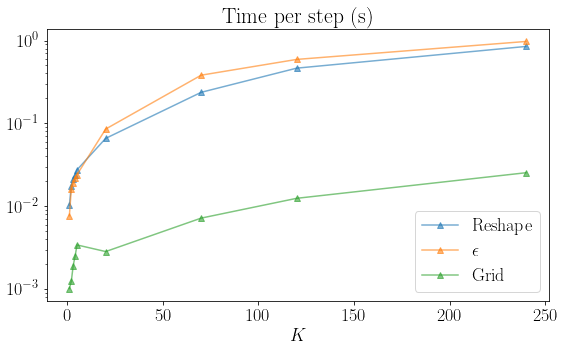

In [391]:
plt.figure(figsize=(9, 5))
plt.plot(K_nums, dftemp2.groupby(["K"]).sum()["solvetime"]/dftemp2.groupby(["K"]).count()["solvetime"], linestyle='-', marker=styles[j], label="Reshape",alpha = 0.6)
plt.plot(K_nums, dftemp.groupby(["K"]).sum()["solvetime"]/dftemp.groupby(["K"]).count()["solvetime"], linestyle='-', marker=styles[j], label="$\epsilon$",alpha = 0.6)
plt.plot(K_nums, dftemp1.groupby(["K"]).sum()["solvetime"]/dftemp1.groupby(["K"]).count()["solvetime"], linestyle='-', marker=styles[j], label="Grid",alpha = 0.6)
plt.xlabel("$K$")
plt.title("Time per step (s)")
plt.yscale("log")
plt.legend()
plt.show()

In [121]:
dftemp.to_csv('dftemp.csv')

In [122]:
dftemp1.to_csv('dftemp1.csv')

In [123]:
dftemp2.to_csv('dftemp2.csv')

In [321]:
dftemp.to_csv('dftemp1_2.csv')

In [488]:
dftemp2

,index,r,K,steps,Rnorm,Opt_val,Eval_val,Loss_val,satisfy,solvetime
0,1620.0,4.5,1.0,0.0,2.738613,0.111670,0.111670,0.111670,1.00,0.172381
1,1621.0,4.5,1.0,1.0,2.743633,0.075975,0.075975,0.075975,1.00,0.096101
2,1622.0,4.5,1.0,2.0,2.753075,0.017622,0.017622,0.017622,1.00,0.094493
3,1623.0,4.5,1.0,3.0,2.766623,-0.054428,-0.054428,-0.054428,1.00,0.093761
4,1624.0,4.5,1.0,4.0,2.784060,-0.132208,-0.132196,-0.132208,0.87,0.099220
...,...,...,...,...,...,...,...,...,...,...
355,1975.0,4.5,320.0,35.0,2.936066,-0.574461,-0.473653,-0.479047,0.00,35.144586
356,1976.0,4.5,320.0,36.0,2.935804,-0.573068,-0.473107,-0.478774,0.00,35.407098
357,1977.0,4.5,320.0,37.0,2.935951,-0.573770,-0.473002,-0.479007,0.00,35.076268
358,1978.0,4.5,320.0,38.0,2.936471,-0.575653,-0.473038,-0.476078,0.00,35.086477
